# Bitcoin Prediction

You can check the source here: https://www.investing.com/crypto/bitcoin/historical-data

The data goes from 2021-03-01 to 2024-02-29. The purpose of this project is to forecast the price of bitcoin (BTC/USD) for the next month based on the last 4 years, For this, the LSTM and GRU models will be used to make the prediction and check which one behaves best in relation to the predicted data. The focus is to predict the trend for the next month since pontual forecasting in this scenario is quite complex.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kendalltau, jarque_bera
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, GRU, Dense
import os

In [2]:
# Load dataset

df = pd.read_csv('../src/bitcoin-history.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/29/2024,"61,169.3","62,467.1","63,653.4","60,512.5",119.29K,-2.08%
1,02/28/2024,"62,467.6","57,048.7","63,915.3","56,704.9",173.64K,9.48%
2,02/27/2024,"57,056.2","54,491.1","57,555.2","54,464.0",100.48K,4.70%
3,02/26/2024,"54,495.1","51,722.7","54,899.1","50,925.2",78.05K,5.36%
4,02/25/2024,"51,722.7","51,572.1","51,952.0","51,299.0",23.61K,0.29%


In [3]:
# Data information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1096 non-null   object
 1   Price     1096 non-null   object
 2   Open      1096 non-null   object
 3   High      1096 non-null   object
 4   Low       1096 non-null   object
 5   Vol.      1096 non-null   object
 6   Change %  1096 non-null   object
dtypes: object(7)
memory usage: 60.1+ KB


In [4]:
### Data treatment ###

# Adjust price, open, high and low

for column in list(df.columns[1:5]):
    df[column] = pd.to_numeric(df[column].str.replace(',', '')).astype(float)
    
# Function to convert last columns

def convert_to_numeric(data):
    suffixes = {'K': 1e3, 'M': 1e6, 'B': 1e9, '%': 1e2}
    return float(data[:-1]) * suffixes[data[-1]]

# Ajust vol.

df['Vol.'] = df['Vol.'].apply(convert_to_numeric)

# Adjust change %                             

df['Change %'] = df['Change %'].apply(convert_to_numeric)

# Name changes

df = df.rename(columns={'Vol.': 'Volume'})
df = df.rename(columns={'Change %': 'Change'})

# Convert to temporal series

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df = df.set_index('Date').asfreq('D')
df.head()

,Price,Open,High,Low,Volume,Change
Date,,,,,,
2021-03-01,49595.5,45160.5,49774.0,45008.8,137520.0,981.0
2021-03-02,48424.2,49595.6,50191.9,47100.6,102100.0,-236.0
2021-03-03,50395.1,48422.2,52567.9,48159.2,44930.0,407.0
2021-03-04,48428.0,50388.0,51757.7,47521.8,9560.0,-390.0
2021-03-05,48792.5,48363.6,49429.4,46370.1,113640.0,75.0


### Data Analysis

In [5]:
# Data description

df.describe()

,Price,Open,High,Low,Volume,Change
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.000000
mean,35152.305474,35138.407208,35929.718887,34292.790328,5.531716e+07,7.958029
std,12696.919001,12675.976917,13039.115154,12276.301833,3.273136e+08,321.736947
min,15776.200000,15776.600000,16274.600000,15504.200000,2.600000e+02,-1563.000000
25%,24682.625000,24682.525000,25236.050000,24248.325000,5.278000e+04,-130.500000
50%,33077.400000,33071.700000,34063.500000,31670.300000,8.546000e+04,-3.000000
75%,43841.900000,43841.900000,44499.125000,42747.375000,2.016025e+05,154.000000
max,67527.900000,67528.700000,68990.600000,66334.900000,4.470000e+09,1459.000000


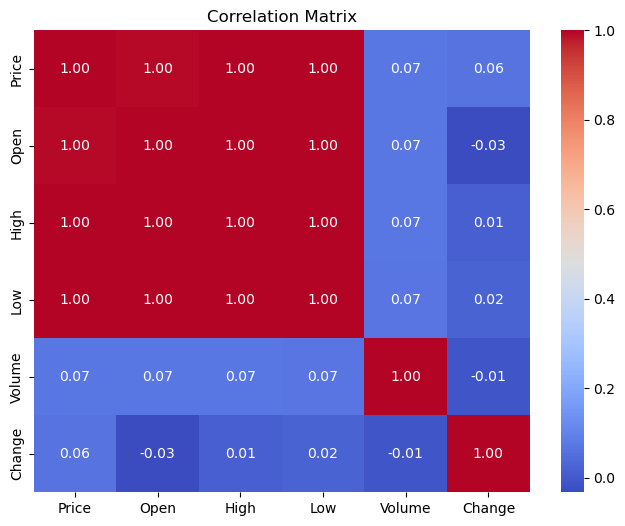

In [6]:
# Correlation matrix

plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

It's observed that the variables volume and change do not show the presence of correlation between other variables. Change is a variable that depends on the price, so it's unfeasible to use it as a predictor variable.

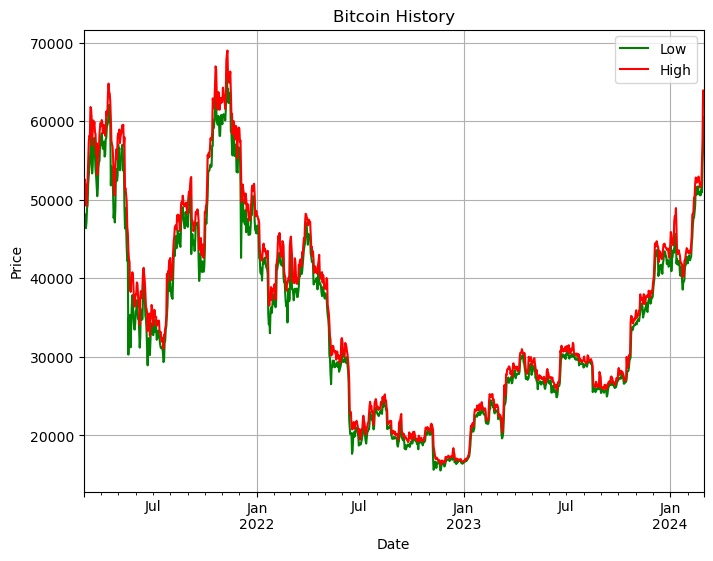

In [7]:
# Show price history

fig, ax = plt.subplots(figsize=(8,6))

df['Low'].plot(ax=ax, color='g')
df['High'].plot(ax=ax, color='r')
plt.title('Bitcoin History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Low', 'High'])
plt.grid(True)
plt.show()

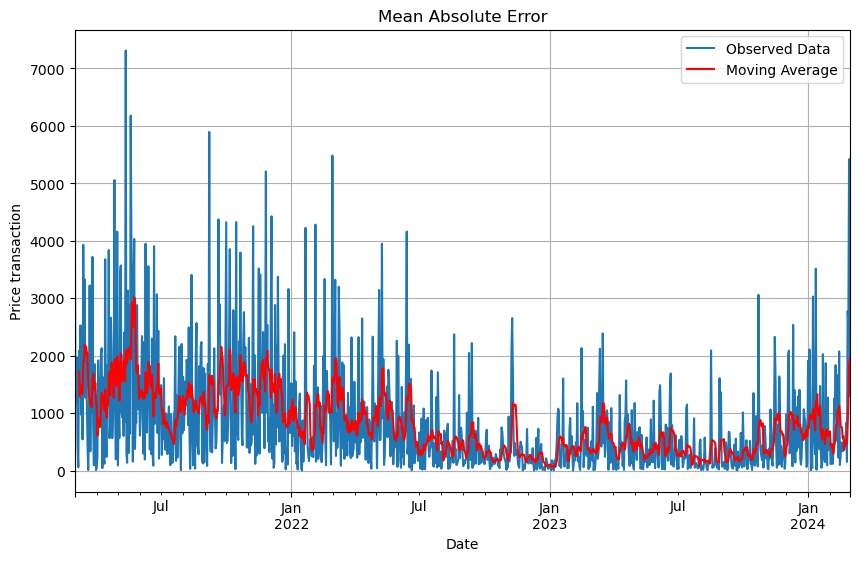

In [8]:
# Price transaction (MAE)

price_mae = abs(df['Price'] - df['Open'])
price_mae_ma = price_mae.rolling(7).mean()

fig, ax = plt.subplots(figsize=(10,6))
price_mae.plot(ax=ax)
price_mae_ma.plot(ax=ax, color='r')
plt.title('Mean Absolute Error')
plt.xlabel('Date')
plt.ylabel('Price transaction')
plt.legend(['Observed Data', 'Moving Average'])
plt.grid(True)
plt.show()

From MAE it's visible that the price variation between open and close is not very significant.

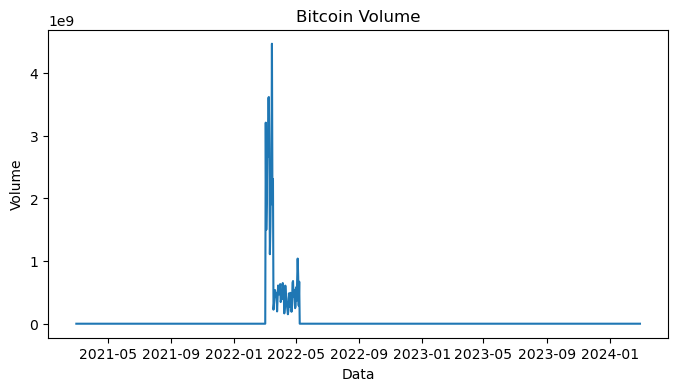

In [9]:
# Volume plot

plt.subplots(figsize=(8,4))
plt.plot(df.index, df['Volume'].values)
plt.title('Bitcoin Volume')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.show()

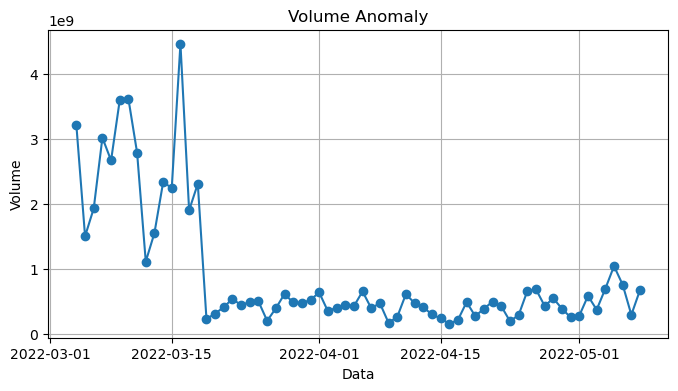

In [10]:
# Volume anomaly

anomaly = df.loc[df['Volume'].values > 1e6]['Volume']

plt.subplots(figsize=(8,4))
plt.plot(anomaly.index, anomaly.values, marker='o')
plt.title('Volume Anomaly')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

In [11]:
# Anomaly describe

anomaly.describe()

count    6.600000e+01
mean     9.165782e+08
std      1.001676e+09
min      1.513100e+08
25%      3.711175e+08
50%      4.815400e+08
75%      7.375025e+08
max      4.470000e+09
Name: Volume, dtype: float64

An anomaly is identified during a specific period of time from the volume data. This anomaly could interfere with the prediction if it were used as an predictor variable. If it were used, it would have to be processed in order to drastically reduce the volatility of the data. The objective of this project is to have all data from the last 4 years, so this variable would be inappropriate as a predictor variable for requering the removal of part of the data. Otherwise, it would be possible to remove the time interval relating to the anomaly and work with the rest of the data because sequential neural network models work on irregular time series.

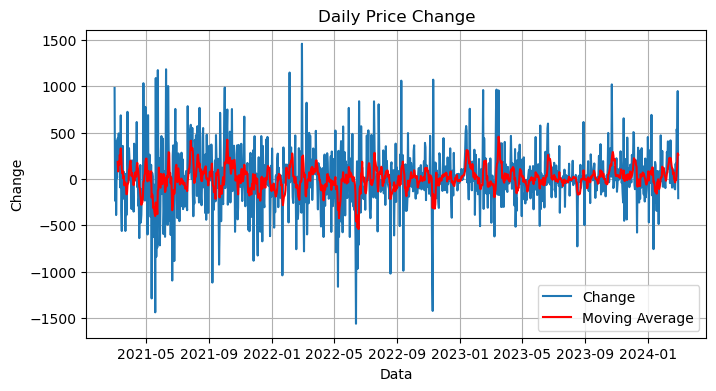

In [12]:
# Daily price change

plt.subplots(figsize=(8,4))
plt.plot(df.index, df['Change'])
plt.plot(df.index, df['Change'].rolling(7).mean(), color='r')
plt.title('Daily Price Change')
plt.xlabel('Data')
plt.ylabel('Change')
plt.legend(['Change', 'Moving Average'], loc='lower right')
plt.grid(True)

plt.show()

The price change appears to follow a stationary behavior over time with amplitude around 3k. Note that this variable depends on the price (close), so it would be inappropriate as a predictor variable for the price of bitcoin. The price change formula is given by:

<center>$C_t(P) = \frac{P_t - P_{t-1}}{P_{t-1}} \implies C_t(P) = \frac{P_t}{P_{t-1}}-1$

### Temporal Series Analysis

In [13]:
# Price variable only

df = df.iloc[:, 0]
df.head()

Date
2021-03-01    49595.5
2021-03-02    48424.2
2021-03-03    50395.1
2021-03-04    48428.0
2021-03-05    48792.5
Freq: D, Name: Price, dtype: float64

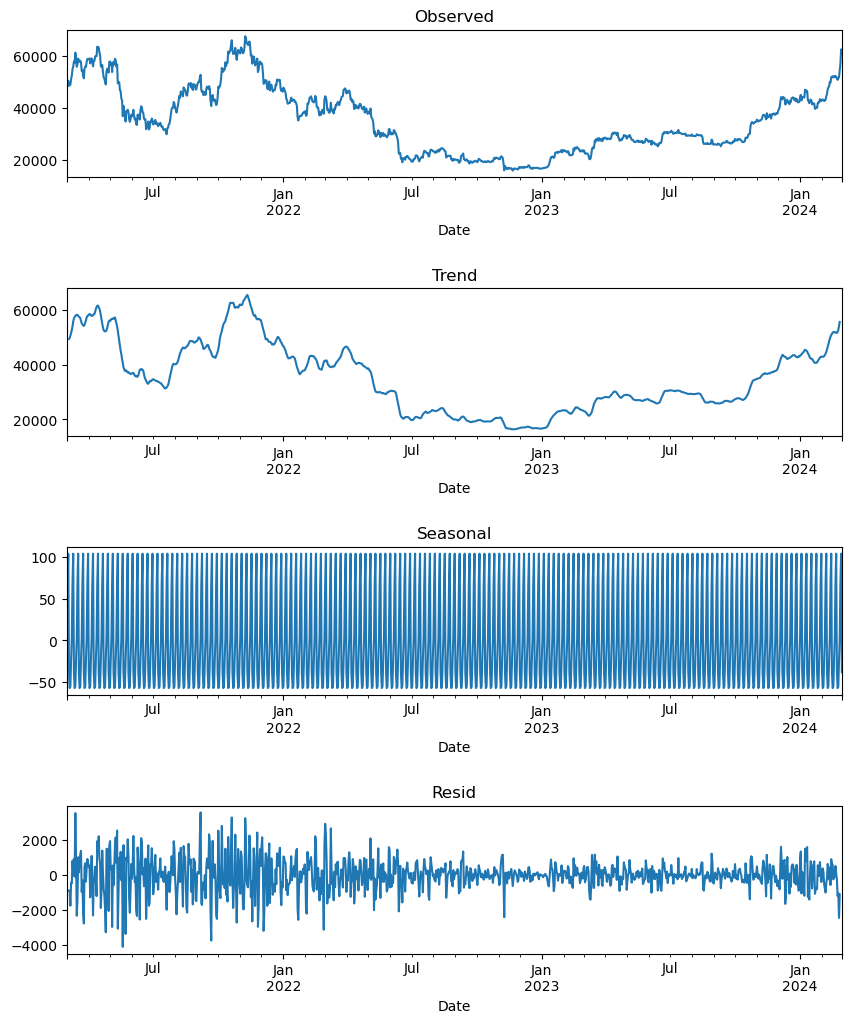

In [14]:
decomp = sm.tsa.seasonal_decompose(df)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

decomp.observed.plot(ax=ax1, title='Observed')
decomp.trend.plot(ax=ax2, title='Trend')
decomp.seasonal.plot(ax=ax3, title='Seasonal')
decomp.resid.plot(ax=ax4, title='Resid')

plt.subplots_adjust(hspace=0.75)

plt.show()

In [15]:
# Kendall test

tau, p_value = kendalltau(range(len(df)), df)

print(f'''Kendall statistic: {tau}
p-value: {p_value}''')

Kendall statistic: -0.24219325465339556
p-value: 3.232544815064721e-33


There is evidence of seasonality in this time series according to the Kendall test. It's possible to identify seasonal periodicity by observing the seasonality graph in the decomposition.

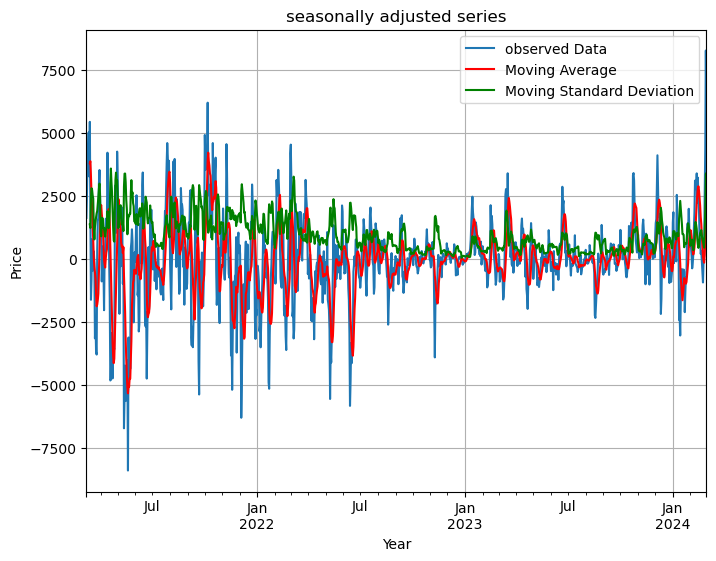

In [16]:
# Seasonally adjusted series

df_des = (df - df.rolling(7).mean()).dropna()
df_des_ma = df_des.rolling(7).mean()
df_des_std = df_des.rolling(7).std()

fig, ax = plt.subplots(figsize=(8,6))

df_des.plot(ax=ax)
df_des_ma.plot(ax=ax, color='r')
df_des_std.plot(ax=ax, color='g')
plt.title('seasonally adjusted series')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['observed Data', 'Moving Average', 'Moving Standard Deviation'])
plt.grid(True)
plt.show()

Deseasonalization helps gain long-term insights. This time series demonstrates instability in the long-term trend.

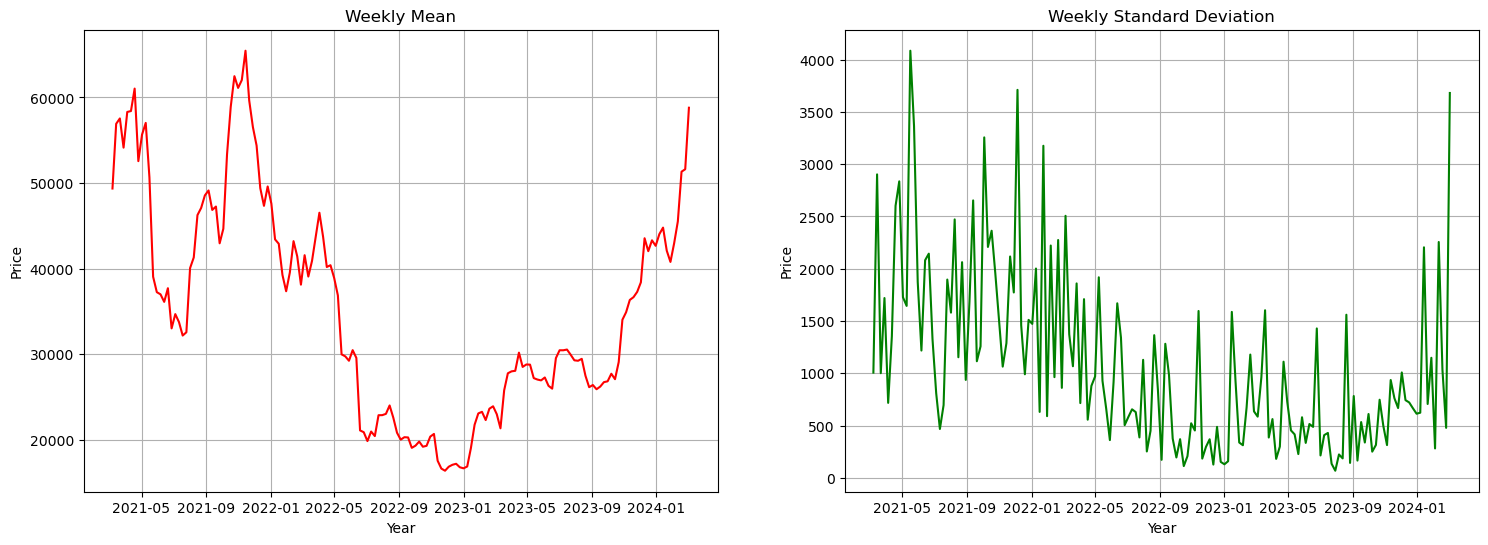

In [17]:
# Weekly analysis

mean_weekly = df.resample('W').mean()
std_weekly = df.resample('W').std()

fig, axes = plt.subplots(1, 2, figsize=(18,6))

axes[0].plot(mean_weekly.index, mean_weekly, color='r')
axes[0].set_title('Weekly Mean')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price')
axes[0].grid(True)

axes[1].plot(std_weekly.index, std_weekly, color='g')
axes[1].set_title('Weekly Standard Deviation')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price')
axes[1].grid(True)

plt.show()

The weekly price average follows a very similar behavior to the daily price. In the case of weekly standard deviation, there's an indication of high price volatility.

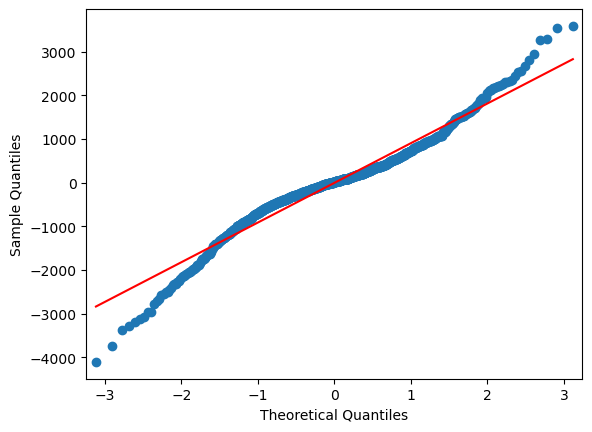

In [18]:
# Check resid with qqplot

sm.qqplot(sm.tsa.seasonal_decompose(df).resid.dropna(), line='s')
plt.show()

In [19]:
# Jarque-Bera test

jb_stat, jb_p = jarque_bera(sm.tsa.seasonal_decompose(df).resid.dropna())

print(f'''Jarque-Bera results
JB statistic: {jb_stat}
p-value: {jb_p}''')

Jarque-Bera results
JB statistic: 263.9841734172204
p-value: 0.0


The residual of the time series does not follow a normal distribution. Although this is not a problem for the LSTM and GRU models, it'll impact the construction of the predictive confidence interval.

### Sequential Neural Networks

In [20]:
# Price normalization

scaler = MinMaxScaler()
price_norm = scaler.fit_transform(df.values.reshape(-1,1))
price_norm

array([[0.65349158],
       [0.6308585 ],
       [0.66894228],
       ...,
       [0.79765496],
       [0.90221964],
       [0.87713254]])

In [21]:
# Training and testing data

train_size = int(len(price_norm) * 0.7)
test_size = len(price_norm) - train_size
train, test = price_norm[0:train_size, :], price_norm[train_size:len(price_norm), :]

In [22]:
# Create dataset function

def create_dataset(dataset):
    X, y = [], []
    for i in range(len(dataset)-n_steps-1):
        a = dataset[i:(i+n_steps), 0]
        X.append(a)
        y.append(dataset[i+n_steps, 0])
    return np.array(X), np.array(y)

In [23]:
# reshaping input data

n_steps = 20

X_train, y_train = create_dataset(train)
X_test, y_test = create_dataset(test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

In [24]:
### LSTM model ###

lstm_model = Sequential()

lstm_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
lstm_model.add(LSTM(units=64, activation='relu'))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Training LSTM model

model_directory = os.path.join(os.getcwd(), 'models') # Get current path

os.makedirs(model_directory, exist_ok=True) # Create new folder

model_path = os.path.join(model_directory, 'lstm.h5') # Add new model

lstm_model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True) # Model checkpoint

lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
                      batch_size=32, callbacks=[lstm_model_checkpoint], verbose=1)

Epoch 1/100
24/24 [==============================] - 2s 19ms/step - loss: 0.1034 - val_loss: 0.0077
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0127 - val_loss: 0.0024
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0044 - val_loss: 0.0017
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0010
Epoc

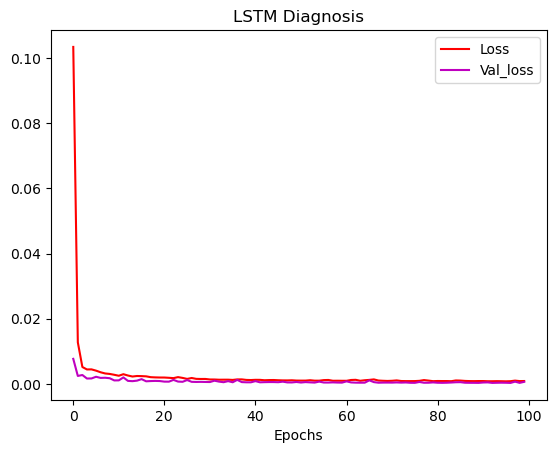

In [26]:
# LSTM diagnosis

lstm_best_model = load_model(model_path)

plt.plot(list(range(len(lstm.history['loss']))), lstm.history['loss'], color='r')
plt.plot(list(range(len(lstm.history['val_loss']))), lstm.history['val_loss'], color='m')
plt.title('LSTM Diagnosis')
plt.xlabel('Epochs')
plt.legend(['Loss', 'Val_loss'])

plt.show()

In [27]:
# Prediction

lstm_train_predict = lstm_best_model.predict(X_train, verbose=0)
lstm_test_predict = lstm_best_model.predict(X_test, verbose=0)

In [28]:
# Inverse normalization transformation

lstm_train = scaler.inverse_transform(lstm_train_predict)
lstm_test = scaler.inverse_transform(lstm_test_predict)

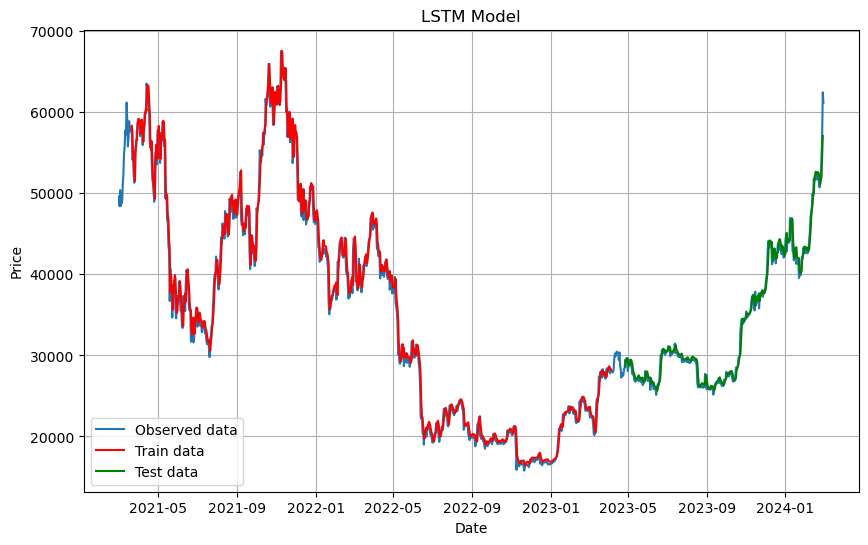

In [29]:
# Results

plt.subplots(figsize=(10,6))
plt.plot(df.index, df.values, label='Observed data')
plt.plot(df.index[n_steps:len(lstm_train)+n_steps], lstm_train, color='r', label='Train data')
plt.plot(df.index[len(lstm_train)+(2*n_steps)+1:len(lstm_train)+len(lstm_test)+(2*n_steps)+1],
         lstm_test, color='g', label='Test data')
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Metrics

print(f'''Train data metrics:
Mean absolute error: {mean_absolute_error(y_train_inv, lstm_train)}
Root mean squared error: {np.sqrt(mean_squared_error(y_train_inv, lstm_train))}
R2 score: {r2_score(y_train_inv, lstm_train)}''')

print(f'''\nTest data metrics
Mean absolute error: {mean_absolute_error(y_test_inv, lstm_test)}
Root mean squared error: {np.sqrt(mean_squared_error(y_test_inv, lstm_test))}
R2 score: {r2_score(y_test_inv, lstm_test)}''')

Train data metrics:
Mean absolute error: 1001.8853044361596
Root mean squared error: 1447.4426667866016
R2 score: 0.9893830887237255

Test data metrics
Mean absolute error: 578.4763240665586
Root mean squared error: 867.983461491895
R2 score: 0.9880950021914808


The LSTM model achieved great results in performance metrics. The fit to the test data was better than the training data because of the considerable reduction in errors while coefficient of determination is almost identical in both scenarios.

In [31]:
### GRU model ###

gru_model = Sequential()

gru_model.add(GRU(units=64, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
gru_model.add(GRU(units=64, activation='relu'))
gru_model.add(Dense(units=1))

gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Training GRU model

model_path = os.path.join(model_directory, 'gru.h5') # Add new model

gru_model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True) # Model checkpoint

gru = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
                      batch_size=32, callbacks=[gru_model_checkpoint], verbose=1)

Epoch 1/100
24/24 [==============================] - 2s 17ms/step - loss: 0.0877 - val_loss: 0.0078
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 7.8427e-04
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 6.0585e-04
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 8.1201e-04
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 5.2546e-04
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 6.6892e-04
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 6.6682e-04
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0011 - val_loss: 5.6970e-04
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 4.5337e-04
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 0.

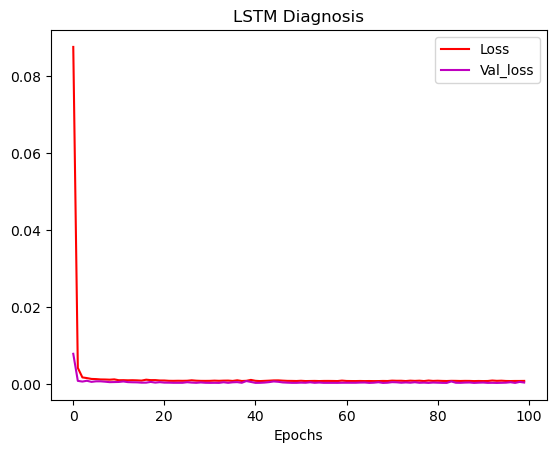

In [33]:
# GRU diagnosis

gru_best_model = load_model(model_path)

plt.plot(list(range(len(gru.history['loss']))), gru.history['loss'], color='r')
plt.plot(list(range(len(gru.history['val_loss']))), gru.history['val_loss'], color='m')
plt.title('LSTM Diagnosis')
plt.xlabel('Epochs')
plt.legend(['Loss', 'Val_loss'])

plt.show()

In [34]:
# Prediction

gru_train_predict = gru_best_model.predict(X_train, verbose=0)
gru_test_predict = gru_best_model.predict(X_test, verbose=0)

In [35]:
# Inverse normalization transformation

gru_train = scaler.inverse_transform(gru_train_predict)
gru_test = scaler.inverse_transform(gru_test_predict)

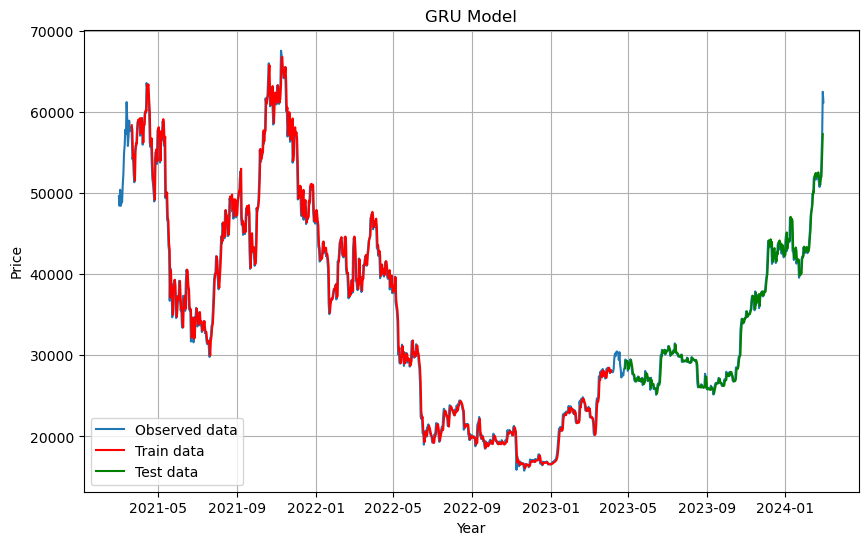

In [36]:
# Results

plt.subplots(figsize=(10,6))
plt.plot(df.index, df.values, label='Observed data')
plt.plot(df.index[n_steps:len(gru_train)+n_steps], gru_train, color='r', label='Train data')
plt.plot(df.index[len(gru_train)+(2*n_steps)+1:len(gru_train)+len(gru_test)+(2*n_steps)+1],
         gru_test, color='g', label='Test data')
plt.title('GRU Model')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
# Metrics

print(f'''Train data metrics:
Mean absolute error: {mean_absolute_error(y_train_inv, gru_train)}
Root mean squared error: {np.sqrt(mean_squared_error(y_train_inv, gru_train))}
R2 score: {r2_score(y_train_inv, gru_train)}''')

print(f'''\nTest data metrics:
Mean absolute error: {mean_absolute_error(y_test_inv, gru_test)}
Root mean squared error: {np.sqrt(mean_squared_error(y_test_inv, gru_test))}
R2 score: {r2_score(y_test_inv, gru_test)}''')

Train data metrics:
Mean absolute error: 926.1891991663874
Root mean squared error: 1390.8843841007883
R2 score: 0.990196582243847

Test data metrics:
Mean absolute error: 511.11996880073065
Root mean squared error: 822.0618597373661
R2 score: 0.9893213729828516


The GRU model also achieved great results in performance metrics. The results are similar to the previous model.

### Forecast

In [38]:
# Forecast function

def model_predict(temp_input, forecast, model):
    # temp_input (data), forecast (predict amount), model ('LSTM' or 'GRU')
    lst_output = []
    i=0
    while (i < forecast):
        if len(temp_input) > n_steps:
            X_input = np.array(temp_input[-n_steps:]).reshape((1, n_steps, 1))
            if model == 'LSTM':
                yhat = lstm_best_model.predict(X_input, verbose=0)
            else:
                yhat = gru_best_model.predict(X_input, verbose=0)
            temp_input = np.concatenate([temp_input, yhat.reshape(1, 1)])
            lst_output.append(yhat[0, 0])
            i += 1
        else:
            X_input = np.array(temp_input).reshape((1, len(temp_input), 1))
            if model == 'LSTM':
                yhat = lstm_best_model.predict(X_input, verbose=0)
            else:
                yhat = gru_best_model.predict(X_input, verbose=0)
                temp_input = np.concatenate([temp_input, yhat.reshape(1, 1)])
                lst_output.append(yhat[0, 0])
            i += 1
    return np.array(lst_output)

In [39]:
# Predict (next month)

date_range = pd.date_range(start='2024-03-01', end='2024-03-31')
forecast = len(date_range)

lstm_predict = model_predict(test, forecast, 'LSTM')
lstm_predict = scaler.inverse_transform(lstm_predict.reshape(-1, 1))
lstm_results = pd.DataFrame({'Date': date_range, 'Price': lstm_predict.reshape(1, -1).flatten()}).set_index('Date').asfreq('D')

gru_predict = model_predict(test, forecast, 'GRU')
gru_predict = scaler.inverse_transform(gru_predict.reshape(-1, 1))
gru_results = pd.DataFrame({'Date': date_range, 'Price': gru_predict.reshape(1, -1).flatten()}).set_index('Date').asfreq('D')

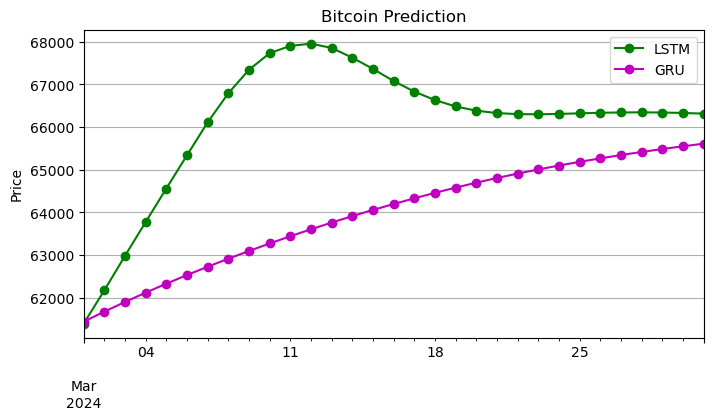

In [40]:
# Prediction

fig, ax = plt.subplots(figsize=(8, 4))

lstm_results.plot(ax=ax, marker='o', color='g')
gru_results.plot(ax=ax, marker='o', color='m')
plt.title('Bitcoin Prediction')
plt.xlabel('')
plt.ylabel('Price')
plt.legend(['LSTM', 'GRU'])
plt.grid(True)
plt.show()

### Bootstrap by Resampling

In [41]:
# Bootstrap function

def bootstrap(sample, seasonality):
    resample = sample.copy()
    amount = int(np.ceil(len(resample) / seasonality))
    for i in range(amount):
        start_index = i * seasonality
        end_index = (i + 1) * seasonality
        np.random.shuffle(resample[start_index:end_index])
    return resample

Bootstrap function implements a resampling bootstrap approach that maintains the seasonal structure of the original data by shuffling elements within seasonal blocks to create new samples used in estimating confidence intervals for predicted data.

In [42]:
# Set bootstrap size and seasonality

bootstrap_size = 10
seasonality = 7

The number of predictions per sample is given by bootstrap_size. It's important to note that this technique requires high computational processing. The advantage of using this function is the robustness of the confidence interval.

In [43]:
# Bootstrap prediction (LSTM)

lstm_bootstrap_predict = []

for _ in range(bootstrap_size):
    bootstrap_sample = bootstrap(price_norm, seasonality)
    
    train_size = int(len(bootstrap_sample) * 0.7)
    test_size = len(bootstrap_sample) - train_size
    train, test = bootstrap_sample[0:train_size, :], bootstrap_sample[train_size:len(price_norm), :]
    
    X_train, y_train = create_dataset(train)
    X_test, y_test = create_dataset(test)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    lstm_bootstrap_model = Sequential()
    lstm_bootstrap_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    lstm_bootstrap_model.add(LSTM(units=64, activation='relu'))
    lstm_bootstrap_model.add(Dense(units=1))
    lstm_bootstrap_model.compile(optimizer='adam', loss='mse')

    lstm_bootstrap = lstm_bootstrap_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
                                              batch_size=32, verbose=0)
    bootstrap_scale = scaler.inverse_transform(model_predict(test, forecast, 'LSTM').reshape(-1, 1)).reshape(1, -1).flatten()
    lstm_bootstrap_predict.extend(bootstrap_scale)
    
    del lstm_bootstrap_model

In [44]:
# Bootstrap Prediction (GRU)

gru_bootstrap_predict = []

for _ in range(bootstrap_size):
    bootstrap_sample = bootstrap(price_norm, seasonality)
    
    train_size = int(len(bootstrap_sample) * 0.7)
    test_size = len(bootstrap_sample) - train_size
    train, test = bootstrap_sample[0:train_size, :], bootstrap_sample[train_size:len(price_norm), :]
    
    X_train, y_train = create_dataset(train)
    X_test, y_test = create_dataset(test)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    gru_bootstrap_model = Sequential()
    gru_bootstrap_model.add(GRU(units=64, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))
    gru_bootstrap_model.add(GRU(units=64, activation='tanh'))
    gru_bootstrap_model.add(Dense(units=1))
    gru_bootstrap_model.compile(optimizer='adam', loss='mse')

    gru_bootstrap = gru_bootstrap_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
                                              batch_size=32, verbose=0)

    bootstrap_scale = scaler.inverse_transform(model_predict(test, forecast, 'GRU').reshape(-1, 1)).reshape(1, -1).flatten()
    gru_bootstrap_predict.extend(bootstrap_scale)
    
    del gru_bootstrap_model

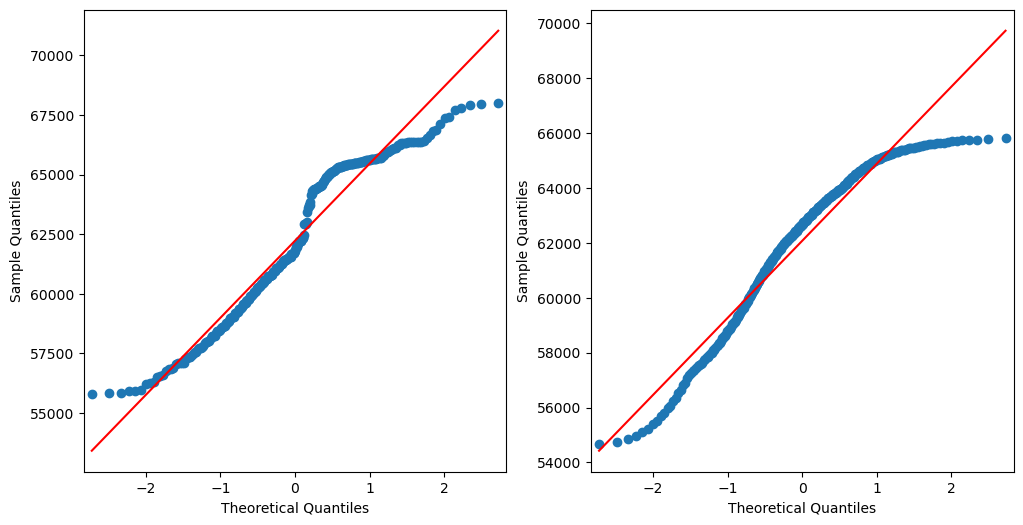

In [45]:
# Normal distribution check

fig, axes = plt.subplots(1, 2, figsize=(12,6))

sm.qqplot(np.array(lstm_bootstrap_predict), line='s', ax=axes[0])
sm.qqplot(np.array(gru_bootstrap_predict), line='s', ax=axes[1])

plt.show()

In [46]:
# Jarque-Bera Test

lstm_stat, lstm_p = jarque_bera(lstm_bootstrap_predict)
gru_stat, gru_p = jarque_bera(gru_bootstrap_predict)

print(f'''LSTM:
JB statistic: {lstm_stat}
p-value: {lstm_p}

GRU:
JB statistic: {gru_stat}
p_value: {gru_p} ''')

LSTM:
JB statistic: 20.78999914556047
p-value: 3.0585039530794944e-05

GRU:
JB statistic: 28.206773510181325
p_value: 7.498544206674396e-07 


The bootstrap set doesn't follow a normal distribution in both cases. It'll be necessary to use non-parametric tests to create the confidence interval. In this case, it is possible to obtain the range through percentiles. For a 95% confidence interval, the range will be between 2.5% and 97.5%.

In [47]:
# Get percentiles

lstm_min = np.percentile(lstm_bootstrap_predict, 2.5)
lstm_max = np.percentile(lstm_bootstrap_predict, 97.5)
gru_min = np.percentile(gru_bootstrap_predict, 2.5)
gru_max = np.percentile(gru_bootstrap_predict, 97.5)

print(f'''Model: min - max
LSTM: {int(lstm_min)} - {int(lstm_max)}
GRU: {int(gru_min)} - {int(gru_max)}''')

Model: min - max
LSTM: 56266 - 66953
GRU: 55637 - 65660


In [49]:
# Config interval

lstm_mid = (lstm_max - lstm_min) / 2
gru_mid = (gru_max - gru_min) / 2

lstm_ci, gru_ci = np.empty((len(lstm_results), 2)), np.empty((len(lstm_results), 2))

lstm_ci[:, 0] = [x - lstm_mid for x in lstm_results.values.reshape(1, -1).flatten()]
lstm_ci[:, 1] = [x + lstm_mid for x in lstm_results.values.reshape(1, -1).flatten()]
gru_ci[:, 0] = [y - gru_mid for y in gru_results.values.reshape(1, -1).flatten()]
gru_ci[:, 1] = [y + gru_mid for y in gru_results.values.reshape(1, -1).flatten()]

### Results

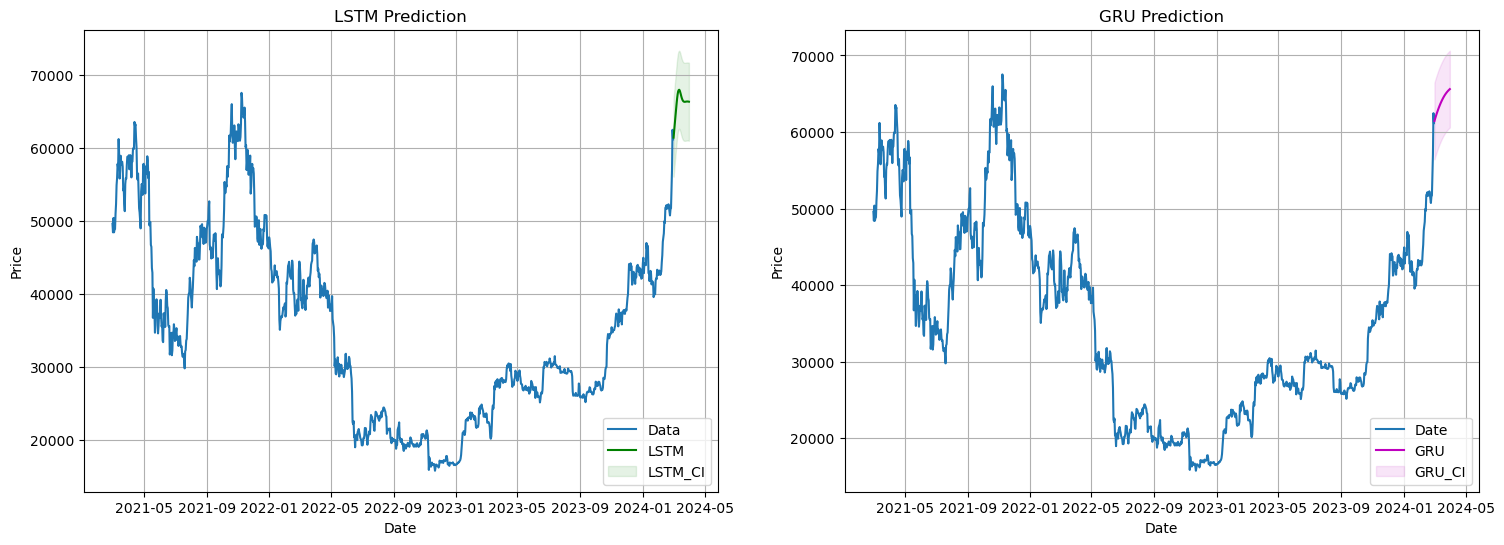

In [50]:
# Prediction (LSTM vs GRU)

plt.subplots(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(df.index, df.values)
plt.plot(lstm_results.index, lstm_results.values, color='g')
plt.fill_between(x=lstm_results.index, y1=lstm_ci[:, 0], y2=lstm_ci[:, 1], color='g', alpha=0.1)
plt.title('LSTM Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Data', 'LSTM', 'LSTM_CI'], loc='lower right')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(df.index, df.values)
plt.plot(gru_results.index, gru_results.values, color='m')
plt.fill_between(x=gru_results.index, y1=gru_ci[:, 0], y2=gru_ci[:, 1], color='m', alpha=0.1)
plt.title('GRU Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Date', 'GRU', 'GRU_CI'], loc='lower right')
plt.grid(True)

plt.show()

In [51]:
# Real data

df_real = pd.read_csv('../src/bitcoin-march.csv')
df_real.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2024,"70,699.0","69,608.5","71,219.2","69,576.6",39.97K,1.56%
1,03/30/2024,"69,611.5","69,872.3","70,321.2","69,564.9",29.87K,-0.37%
2,03/29/2024,"69,871.7","70,766.7","70,907.0","69,090.9",58.99K,-1.26%
3,03/28/2024,"70,762.1","69,449.4","71,542.5","68,956.9",72.49K,1.90%
4,03/27/2024,"69,442.4","69,999.2","71,670.8","68,428.6",112.88K,-0.80%


In [52]:
# Get temporal series for real data

df_real = df_real.iloc[:, :2]
df_real['Price'] = pd.to_numeric(df_real['Price'].str.replace(',', '')).astype(float)
df_real['Date'] = pd.to_datetime(df_real['Date'], format='%m/%d/%Y')
df_real = df_real.set_index('Date').asfreq('D')
df_real.head()

,Price
Date,
2024-03-01,62397.7
2024-03-02,61994.5
2024-03-03,63135.8
2024-03-04,68270.1
2024-03-05,63792.6


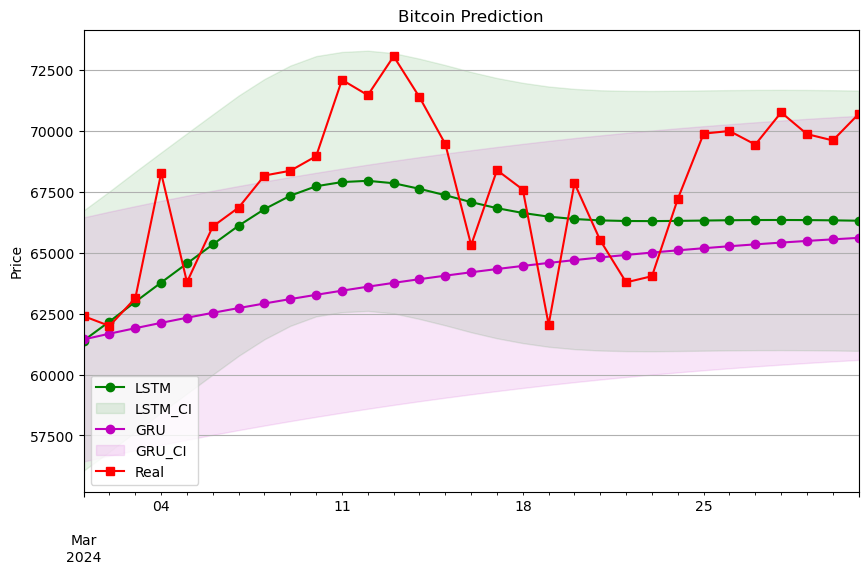

In [53]:
# Full prediction

fig, ax = plt.subplots(figsize=(10, 6))

lstm_results.plot(ax=ax, marker='o', color='g')
plt.fill_between(x=lstm_results.index, y1=lstm_ci[:, 0], y2=lstm_ci[:, 1], color='g', alpha=0.1)
gru_results.plot(ax=ax, marker='o', color='m')
plt.fill_between(x=gru_results.index, y1=gru_ci[:, 0], y2=gru_ci[:, 1], color='m', alpha=0.1)
df_real.plot(ax=ax, marker='s', color='r')
plt.title('Bitcoin Prediction')
plt.xlabel('')
plt.ylabel('Price')
plt.legend(['LSTM', 'LSTM_CI', 'GRU', 'GRU_CI', 'Real'], loc='lower left')
plt.grid(True)
plt.show()

In [54]:
# Metrics

print(f'''LSTM metrics:
Mean absolute error: {mean_absolute_error(df_real.values, lstm_results)}
Root mean squared error: {np.sqrt(mean_squared_error(df_real.values, lstm_results))}''')

print(f'''\nGRU metrics:
Mean absolute error: {mean_absolute_error(df_real.values, gru_results)}
Root mean squared error: {np.sqrt(mean_squared_error(df_real.values, gru_results))}''')

LSTM metrics:
Mean absolute error: 2359.5655493951617
Root mean squared error: 2794.5191916889494

GRU metrics:
Mean absolute error: 4000.5510836693547
Root mean squared error: 4651.584709292841


The LSTM model presents lower MAE and RMSE. For the hyperparameters and layers used in building the models, the best model in this case is LSTM. You can see that all real data was captured by the LSTM confidence interval, unlike GRU which captured partially. Both models indicated a growth trend over time following the behavior of real data overall.